In [1]:
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

# Load the tokenizer for MathBERT
tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBERT")

class ContrastiveDataset(Dataset):
    def __init__(self, texts, cluster_labels, tokenizer, max_length=128):
        self.texts = texts
        self.cluster_labels = cluster_labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Group samples by cluster
        self.cluster_to_samples = {}
        for i, cluster in enumerate(cluster_labels):
            if cluster not in self.cluster_to_samples:
                self.cluster_to_samples[cluster] = []
            self.cluster_to_samples[cluster].append(i)
        
        # Create triplets
        self.triplets = self._create_triplets()
    
    def _create_triplets(self):
        triplets = []
        for anchor_idx, anchor_cluster in enumerate(self.cluster_labels):
            # Find positive samples (same cluster)
            pos_samples = [idx for idx in self.cluster_to_samples[anchor_cluster] if idx != anchor_idx]
            if not pos_samples:
                continue  # Skip if no positive samples
                
            # Find negative samples (different clusters)
            neg_clusters = [c for c in self.cluster_to_samples.keys() if c != anchor_cluster]
            if not neg_clusters:
                continue  # Skip if no negative clusters
                
            # Sample one positive and one negative
            pos_idx = random.choice(pos_samples)
            neg_cluster = random.choice(neg_clusters)
            neg_idx = random.choice(self.cluster_to_samples[neg_cluster])
            
            triplets.append((anchor_idx, pos_idx, neg_idx))
        
        return triplets
    
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        anchor_idx, pos_idx, neg_idx = self.triplets[idx]
        
        # Tokenize all three texts
        anchor_encoding = self.tokenizer(
            self.texts[anchor_idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        positive_encoding = self.tokenizer(
            self.texts[pos_idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        negative_encoding = self.tokenizer(
            self.texts[neg_idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        
        # Return as a dictionary for convenience
        return {
            "anchor_input_ids": anchor_encoding["input_ids"].squeeze(),
            "anchor_attention_mask": anchor_encoding["attention_mask"].squeeze(),
            "positive_input_ids": positive_encoding["input_ids"].squeeze(),
            "positive_attention_mask": positive_encoding["attention_mask"].squeeze(),
            "negative_input_ids": negative_encoding["input_ids"].squeeze(),
            "negative_attention_mask": negative_encoding["attention_mask"].squeeze(),
            "anchor_cluster": self.cluster_labels[anchor_idx],
            "positive_cluster": self.cluster_labels[pos_idx],
            "negative_cluster": self.cluster_labels[neg_idx]
        }

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class MathBERTContrastive(nn.Module):
    def __init__(self, model_name="tbs17/MathBERT", embedding_dim=768, projection_dim=128):
        super(MathBERTContrastive, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Projection head for contrastive learning
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)
        )
        
    def forward(self, input_ids, attention_mask):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the [CLS] token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        # Project to the lower-dimensional space
        projection = self.projection(cls_output)
        
        # Normalize the projection (important for contrastive learning)
        normalized_projection = F.normalize(projection, p=2, dim=1)
        
        return normalized_projection

# Triplet Loss function
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)  # squared distance
        distance_negative = (anchor - negative).pow(2).sum(1)  # squared distance
        
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [3]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import time
import tqdm

def train_contrastive_model(model, train_dataloader, val_dataloader=None, 
                           epochs=5, learning_rate=2e-5, weight_decay=0.01,
                           margin=1.0, device="cuda"):
    
    # Move model to device
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    
    # Loss function
    criterion = TripletLoss(margin=margin)
    
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        
        running_loss = 0.0
        for batch in tqdm.tqdm(train_dataloader):
            # Move batch to device
            anchor_input_ids = batch["anchor_input_ids"].to(device)
            anchor_attention_mask = batch["anchor_attention_mask"].to(device)
            positive_input_ids = batch["positive_input_ids"].to(device)
            positive_attention_mask = batch["positive_attention_mask"].to(device)
            negative_input_ids = batch["negative_input_ids"].to(device)
            negative_attention_mask = batch["negative_attention_mask"].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            anchor_embedding = model(anchor_input_ids, anchor_attention_mask)
            positive_embedding = model(positive_input_ids, positive_attention_mask)
            negative_embedding = model(negative_input_ids, negative_attention_mask)
            
            # Calculate loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            
            running_loss += loss.item()
        
        # Print epoch stats
        avg_train_loss = running_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Validation (if provided)
        if val_dataloader:
            val_loss = evaluate_model(model, val_dataloader, criterion, device)
            print(f"Validation loss: {val_loss:.4f}")
    
    return model

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            anchor_input_ids = batch["anchor_input_ids"].to(device)
            anchor_attention_mask = batch["anchor_attention_mask"].to(device)
            positive_input_ids = batch["positive_input_ids"].to(device)
            positive_attention_mask = batch["positive_attention_mask"].to(device)
            negative_input_ids = batch["negative_input_ids"].to(device)
            negative_attention_mask = batch["negative_attention_mask"].to(device)
            
            # Forward pass
            anchor_embedding = model(anchor_input_ids, anchor_attention_mask)
            positive_embedding = model(positive_input_ids, positive_attention_mask)
            negative_embedding = model(negative_input_ids, negative_attention_mask)
            
            # Calculate loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [6]:
import pandas as pd
import os

df = pd.read_json(os.path.abspath("..\\..\\benchmark\\benchmark_v2\\benchmark_v2.json"))
df

,text
Chinese Remainder Theorem,[Solving $x \equiv 2 \mod 3$ and $x \equiv 3 \...
Diophantine Equations,[Solving $3x + 5y = 1$ using the extended Eucl...
Divisibility,[From (1) it follows that $A(x_{1}+y_{1})=p^{k...
Euler’s Theorem,"[By Euler’s Theorem, $10^{\varphi(f k)}\equiv1..."
Extremal Principles,"[If $x\geq3$ , $y\geq3$ , $z\geq3$ then $x y z..."
Fermat’s Little Theorem,[The formula in our problem shows that the sum...
Modular Arithmetics,[Assume that we have a prime $p$ such that $p|...
Pigeonhole Principle,[Let $S$ be the set of nonnegative integers le...
Prime Numbers,[Assume that we have a prime $p$ such that $p|...
Quadratic Residues,"[If $n$ is even, then $p\equiv3$ (mod 4) and $..."


In [7]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

df = df.explode("text").reset_index().rename({"index": "label"}, axis=1)
labels = df['label'].unique()
label_maping = {labels[i]: i for i in range(len(labels))}
df['label'] = df.apply(lambda x: label_maping[x['label']], axis=1)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_texts = train_df['text'].to_list()
train_labels = train_df['label'].to_list()

In [12]:
# Example usage (you'll need to adapt this to your actual data)

# Create dataset and dataloader
dataset = ContrastiveDataset(train_texts, train_labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize the model
model = MathBERTContrastive()

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = train_contrastive_model(
    model, 
    dataloader, 
    epochs=10, 
    learning_rate=2e-5,
    device=device
)

Epoch 1/3


100%|██████████| 5/5 [00:39<00:00,  7.99s/it]


Average training loss: 0.9286
Epoch 2/3


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Average training loss: 0.7526
Epoch 3/3


100%|██████████| 5/5 [00:40<00:00,  8.06s/it]

Average training loss: 0.6459


In [29]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from collections import Counter

def get_embeddings(model, tokenizer, texts, device, batch_size=32):
    """
    Returns a (N, D) array of projection-head embeddings for a list of texts.
    """
    model.eval()
    embeds = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            toks  = tokenizer(batch,
                              return_tensors='pt',
                              padding=True,
                              truncation=True).to(device)
            # get [CLS] hidden state
            z = model(**{"input_ids": toks['input_ids'], "attention_mask": toks['attention_mask']})                         # (B, D)
            embeds.append(z.cpu().numpy())
    return np.vstack(embeds)  # (N, D)

def test_clustering_performance(model, tokenizer, clusters, device):
    """
    clusters: dict[int, List[str]] mapping true cluster id → list of texts
    Returns: dict with ARI, NMI, Purity
    """
    # 1) flatten texts & labels
    texts, true_labels = [], []
    for cid, docs in clusters.items():
        texts.extend(docs)
        true_labels.extend([cid] * len(docs))
    true_labels = np.array(true_labels)

    # 2) get embeddings
    X = get_embeddings(model, tokenizer, texts, device)

    # 3) K-Means
    kmeans = KMeans(n_clusters=len(clusters), random_state=42)
    pred_labels = kmeans.fit_predict(X)

    # 4) metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)

    # 5) purity
    # for each predicted cluster, find the most common true label
    total = len(texts)
    correct = 0
    for pid in np.unique(pred_labels):
        mask = pred_labels == pid
        true_in_cluster = true_labels[mask]
        most_common = Counter(true_in_cluster).most_common(1)[0][1]
        correct += most_common
    purity = correct / total

    return {
        "ARI": ari,
        "NMI": nmi,
        "Purity": purity
    }


In [14]:
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, tokenizer, clusters, device,
                           batch_size=32, pca_components=2,
                           random_state=42):
    """
    clusters: dict[int, List[str]] mapping true cluster → list of texts
    Returns:
      metrics: dict with 'ARI', 'NMI', 'Purity'
      fig: matplotlib.figure.Figure showing 2D scatter of embeddings
    """
    # 1) flatten texts & labels
    texts, true_labels = [], []
    for cid, docs in clusters.items():
        texts.extend(docs)
        true_labels.extend([cid] * len(docs))
    true_labels = np.array(true_labels)

    # 2) get embeddings (using your get_embeddings helper)
    X = get_embeddings(model, tokenizer, texts, device, batch_size)  # shape (N, D)

    # 3) K-Means clustering
    kmeans = KMeans(n_clusters=len(clusters), random_state=random_state)
    pred_labels = kmeans.fit_predict(X)

    # 4) compute metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    # purity
    total = len(texts)
    correct = 0
    for pid in np.unique(pred_labels):
        mask = pred_labels == pid
        most_common = Counter(true_labels[mask]).most_common(1)[0][1]
        correct += most_common
    purity = correct / total

    metrics = {"ARI": ari, "NMI": nmi, "Purity": purity}

    # 5) PCA to 2D
    pca = PCA(n_components=pca_components, random_state=random_state)
    coords = pca.fit_transform(X)  # shape (N, 2)

    # 6) plot
    fig, ax = plt.subplots(figsize=(6,6))
    scatter = ax.scatter(coords[:,0], coords[:,1],
                         c=true_labels,
                         cmap='tab10',
                         alpha=0.7,
                         edgecolors='k')
    ax.set_title("2D PCA of Strategy Embeddings")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    legend1 = ax.legend(*scatter.legend_elements(),
                        title="True Cluster",
                        loc="upper right",
                        bbox_to_anchor=(1.25, 1))
    ax.add_artist(legend1)
    plt.tight_layout()

    return metrics, fig


In [32]:
test_clusters = test_df.groupby("label")['text'].agg(list).reset_index()
clusters = {}
for row in test_clusters.iterrows():
    label = row[1]['label']
    text = row[1]['text']
    clusters[label] = text

ARI:    0.1231
NMI:    0.6553
Purity: 0.6000


C:\Users\mokrota\AppData\Local\Temp\ipykernel_37480\1515315678.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()   # or plt.show()


<function matplotlib.pyplot.bar(x: 'float | ArrayLike', height: 'float | ArrayLike', width: 'float | ArrayLike' = 0.8, bottom: 'float | ArrayLike | None' = None, *, align: "Literal['center', 'edge']" = 'center', data=None, **kwargs) -> 'BarContainer'>

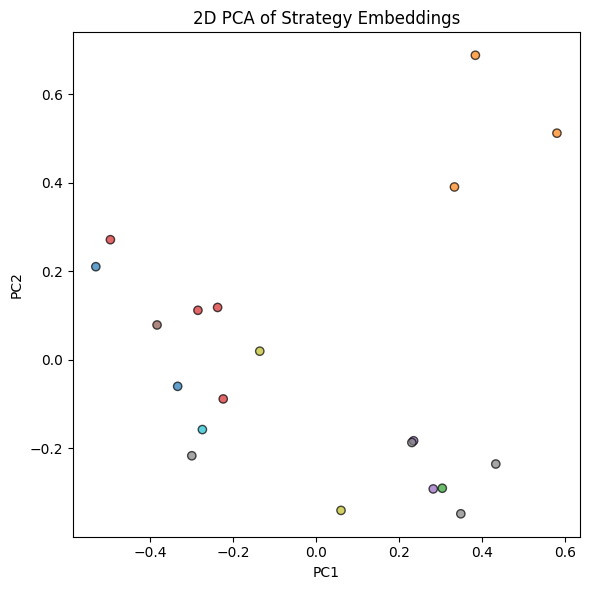

In [33]:

metrics, fig = evaluate_and_visualize(model, tokenizer, clusters, device)
print(f"ARI:    {metrics['ARI']:.4f}")
print(f"NMI:    {metrics['NMI']:.4f}")
print(f"Purity: {metrics['Purity']:.4f}")
fig.show()   # or plt.show()
plt.bar

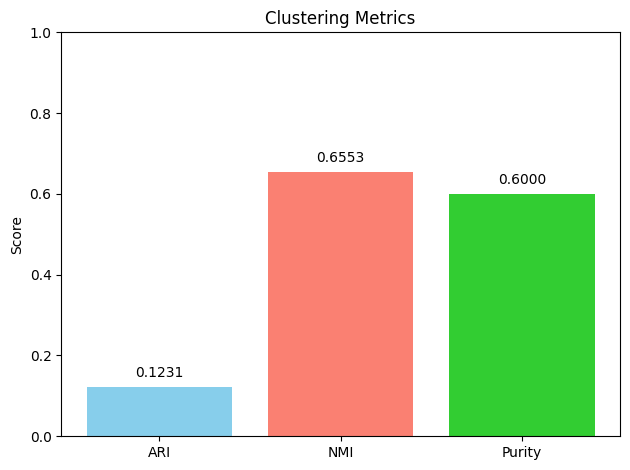

In [34]:
fig, ax = plt.subplots()
metric_names = list(metrics.keys())
metric_values = [metrics[name] for name in metric_names]

bars = ax.bar(metric_names, metric_values, color=['skyblue', 'salmon', 'limegreen'])

# Set limits assuming metrics are all in [0, 1]
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Clustering Metrics")

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # Offset label above the bar
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()
